# Comparison beteween homemade and SkLearn Decision Tree on iris dataset

## I\) Homemade Decision Tree

### Usefull Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
import numpy as np

### Visualization of the Dataset

In [2]:
df = pd.read_csv("Datasets/Iris.csv")
print(df.head())
print(df.info())
print(len(df))

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None
150


### Plotting the data in 2D

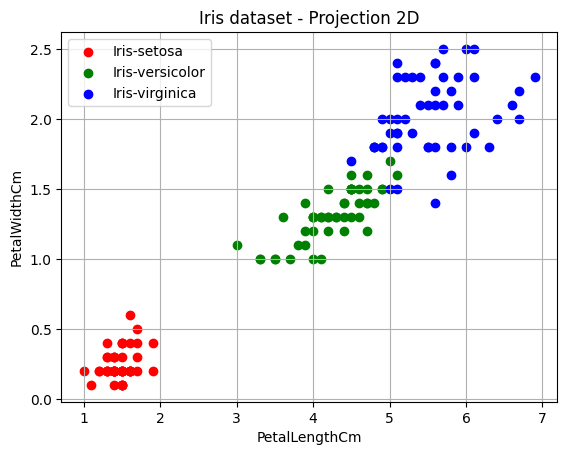

In [3]:
# We will focus only on Petal shape
x_feature = "PetalLengthCm"
y_feature = "PetalWidthCm"

colors = {
    "Iris-setosa": "red",
    "Iris-versicolor": "green",
    "Iris-virginica": "blue"
}


for species, group in df.groupby("Species"):
    plt.scatter(group[x_feature], group[y_feature], 
                label=species, color=colors[species])


plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Iris dataset - Projection 2D")
plt.legend()
plt.grid(True)
plt.show()

### Splitting the data into Train set and Test set

<Axes: xlabel='PetalLengthCm', ylabel='PetalWidthCm'>

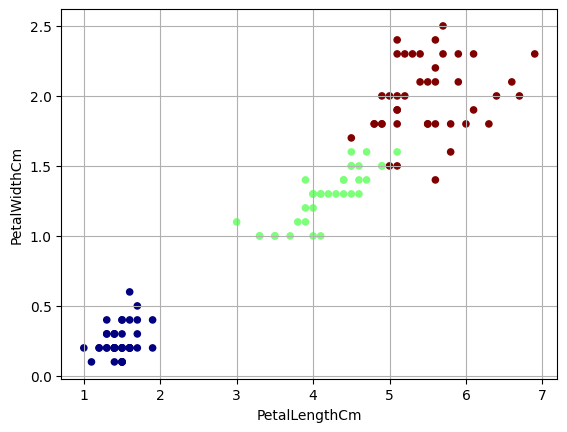

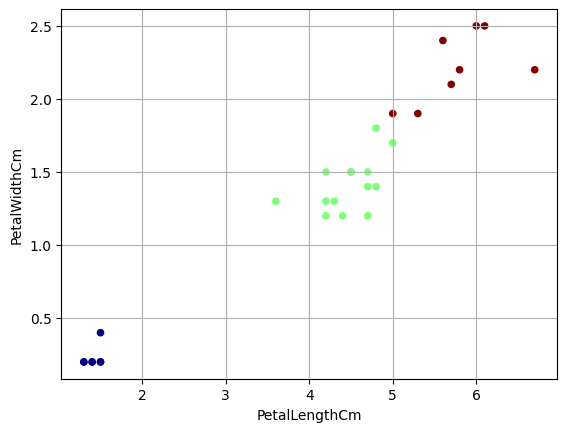

In [4]:
df_melange = df.sample(frac=1)
df_melange['Species_num'] = df_melange['Species'].astype('category').cat.codes
df_train = df_melange[0 : 120]
df_valid = df_melange[120 : ]

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

df_train.plot(kind = "scatter", x= "PetalLengthCm", y ="PetalWidthCm", grid=True, c="Species_num",  cmap="jet", colorbar=False)
df_valid.plot(kind = "scatter", x= "PetalLengthCm", y ="PetalWidthCm", grid=True, c="Species_num",  cmap="jet", colorbar=False)

### Define a Gini Loss function

In [5]:
#This function calculates the Gini_Loss for a chosen couple (feature, threshold)
def Gini_Loss(df, feature, threshold) : 
    df_left = df[df[feature] < threshold]
    df_right = df[df[feature] >= threshold]
    n = len(df)

    #We first caluclate the Gini scor on each side of our node
    def Gini_Score(sub_df) :
        if len(sub_df) == 0:
            return 0 
        species_list = list(sub_df["Species"].unique())
        df_repartition = sub_df.groupby("Species").size()
        gini_Score = 1
        for specie in species_list : 
            gini_Score = gini_Score - (df_repartition[specie]/len(sub_df))**2
        return gini_Score
    
    #Then we are able to establish the global loss of our node
    gini_Loss = (len(df_left) / n) * Gini_Score(df_left) + (len(df_right) / n) * Gini_Score(df_right)

    return gini_Loss, df_left, df_right

### Trying to find the first optimal couple (fature, threshold)

In [6]:
list_of_features = df.columns.tolist()
list_of_features.remove("Id")
list_of_features.remove("Species")
list_of_features.remove("SepalLengthCm")
list_of_features.remove("SepalWidthCm")

best_feature = None
best_threshold = None
best_gini = float("inf")
min_samples_split = 5

#We test each feature to find the best threshold
for feature in list_of_features:
    max_val = df_train[feature].max()
    min_val = df_train[feature].min()
    thresholds = list(np.linspace(min_val, max_val, 500))
    rd.shuffle(thresholds)  #random order of thresholds

    for threshold in thresholds: 
        gini_Loss, df_left, df_right = Gini_Loss(df_train, feature, threshold)

        if len(df_train["Species"].unique()) == 1:
            continue
        if len(df_train) < min_samples_split:
            continue
        if len(df_left) == 0 or len(df_right) == 0:
            continue

        if gini_Loss < best_gini: 
            best_gini = gini_Loss
            best_feature = feature
            best_threshold = threshold


print(best_threshold)
print(best_feature)
print(best_gini)


2.797194388777555
PetalLengthCm
0.3181818181818183


### Trainning the model

In [7]:
#This function will build our tree by finding at each step wich couple (feature, theshold) minimize our GiniLoss
def build_tree(df, min_samples_split=5, max_depth=2, depth=0):

    #It's a recursive function because each step we divide our dataset in 2 and we have to do the same things on those 2 new dataset so we define some stopping conditions
    if len(df["Species"].unique()) == 1:
        return {"value": df["Species"].iloc[0]}

    if len(df) < min_samples_split or depth >= max_depth:
        majority_class = df["Species"].mode()[0]
        return {"value": majority_class}

    best_feature = None
    best_threshold = None
    best_gini = float("inf")
    best_left = None
    best_right = None

    features = [f for f in df.columns if f not in ["Id", "Species", "SepalLengthCm", "SepalWidthCm", 'Species_num']]

    #Testing several features and threshold to find the bests
    for feature in features:
        thresholds = np.linspace(df[feature].min(), df[feature].max(), 25)
        for threshold in thresholds:
            gini, df_left, df_right = Gini_Loss(df, feature, threshold)
            if len(df_left) == 0 or len(df_right) == 0:
                continue
            if gini < best_gini:
                best_gini = gini
                best_feature = feature
                best_threshold = threshold
                best_left = df_left
                best_right = df_right

    if best_feature is None:
        majority_class = df["Species"].mode()[0]
        return {"value": majority_class}

    #We do the same on our new left and right datasets
    left_tree = build_tree(best_left, min_samples_split, max_depth, depth + 1)
    right_tree = build_tree(best_right, min_samples_split, max_depth, depth + 1)

    return {
        "feature": best_feature,
        "threshold": best_threshold,
        "left": left_tree,
        "right": right_tree
    }


In [8]:
tree = build_tree(df_train)

print(tree)

{'feature': 'PetalLengthCm', 'threshold': np.float64(1.9833333333333334), 'left': {'value': 'Iris-setosa'}, 'right': {'feature': 'PetalWidthCm', 'threshold': np.float64(1.625), 'left': {'value': 'Iris-versicolor'}, 'right': {'value': 'Iris-virginica'}}}


### Testing the model on validation data

In [9]:
def decision_tree_inference(df_valid_instance, tree) : 
    if "value" in tree : 
        return tree["value"]
    else :
        feature = tree["feature"]
        threshold = tree["threshold"]
    if df_valid_instance[feature] <= threshold : 
        return decision_tree_inference(df_valid_instance, tree["left"])
    else :
        return decision_tree_inference(df_valid_instance, tree["right"])

In [10]:
true_answers = 0
false_answers = 0

for i in range(0, len(df_valid)) : 
    model_answer = decision_tree_inference(df_valid.iloc[i], tree)
    df_valid.loc[i, "ModelAnswer"] = model_answer
    if model_answer == df_valid.loc[i, "Species"] : 
        true_answers += 1
    else : 
        false_answers += 1

print(f"True answers : {true_answers}")
print(f"False answers : {false_answers}")
print(df_valid[["Species", "ModelAnswer"]])


True answers : 28
False answers : 2
            Species      ModelAnswer
0    Iris-virginica   Iris-virginica
1    Iris-virginica   Iris-virginica
2       Iris-setosa      Iris-setosa
3       Iris-setosa      Iris-setosa
4       Iris-setosa      Iris-setosa
5       Iris-setosa      Iris-setosa
6   Iris-versicolor   Iris-virginica
7       Iris-setosa      Iris-setosa
8   Iris-versicolor  Iris-versicolor
9   Iris-versicolor  Iris-versicolor
10  Iris-versicolor  Iris-versicolor
11  Iris-versicolor  Iris-versicolor
12  Iris-versicolor  Iris-versicolor
13  Iris-versicolor  Iris-versicolor
14   Iris-virginica   Iris-virginica
15      Iris-setosa      Iris-setosa
16   Iris-virginica   Iris-virginica
17   Iris-virginica   Iris-virginica
18  Iris-versicolor  Iris-versicolor
19   Iris-virginica   Iris-virginica
20  Iris-versicolor  Iris-versicolor
21  Iris-versicolor  Iris-versicolor
22  Iris-versicolor  Iris-versicolor
23  Iris-versicolor   Iris-virginica
24  Iris-versicolor  Iris-versicolor
25

### Analazing the results

In [11]:
for species, group in df_valid.groupby("Species"):
    total = len(group)  # nombre total d'exemples pour cette espèce
    errors = (group["ModelAnswer"] != group["Species"]).sum()  # nombre d'erreurs
    error_percent = (errors / total) * 100  # pourcentage d'erreurs
    print(f"Espèce : {species}, Erreurs : {errors}/{total}, Pourcentage : {error_percent:.2f}%")


Espèce : Iris-setosa, Erreurs : 0/7, Pourcentage : 0.00%
Espèce : Iris-versicolor, Erreurs : 2/15, Pourcentage : 13.33%
Espèce : Iris-virginica, Erreurs : 0/8, Pourcentage : 0.00%


### Comparing the results with different depths

In [12]:
depths_to_test = list(range(1, 11))
species_list = df_train["Species"].unique()  # noms des espèces présentes

# Créer un DataFrame vide pour stocker les erreurs
error_table = pd.DataFrame(0.0, index=depths_to_test, columns=species_list)

for depth in depths_to_test:
    tree = build_tree(df_train, max_depth=depth)
    print(tree)
    df_valid_copy = df_valid.copy()

    # Faire les prédictions
    for i in range(len(df_valid_copy)):
        model_answer = decision_tree_inference(df_valid.iloc[i], tree)
        df_valid_copy.loc[i, "ModelAnswer"] = model_answer

    # Calcul des erreurs par espèce
    for species, group in df_valid_copy.groupby("Species"):
        total = len(group)
        errors = (group["ModelAnswer"] != group["Species"]).sum()
        error_percent = (errors / total) * 100
        error_table.loc[depth, species] = error_percent

# (optionnel) renommer l'index
error_table.index.name = "max_depth"

print(error_table)

{'feature': 'PetalLengthCm', 'threshold': np.float64(1.9833333333333334), 'left': {'value': 'Iris-setosa'}, 'right': {'value': 'Iris-virginica'}}
{'feature': 'PetalLengthCm', 'threshold': np.float64(1.9833333333333334), 'left': {'value': 'Iris-setosa'}, 'right': {'feature': 'PetalWidthCm', 'threshold': np.float64(1.625), 'left': {'value': 'Iris-versicolor'}, 'right': {'value': 'Iris-virginica'}}}
{'feature': 'PetalLengthCm', 'threshold': np.float64(1.9833333333333334), 'left': {'value': 'Iris-setosa'}, 'right': {'feature': 'PetalWidthCm', 'threshold': np.float64(1.625), 'left': {'feature': 'PetalLengthCm', 'threshold': np.float64(4.983333333333333), 'left': {'value': 'Iris-versicolor'}, 'right': {'value': 'Iris-virginica'}}, 'right': {'value': 'Iris-virginica'}}}
{'feature': 'PetalLengthCm', 'threshold': np.float64(1.9833333333333334), 'left': {'value': 'Iris-setosa'}, 'right': {'feature': 'PetalWidthCm', 'threshold': np.float64(1.625), 'left': {'feature': 'PetalLengthCm', 'threshold':

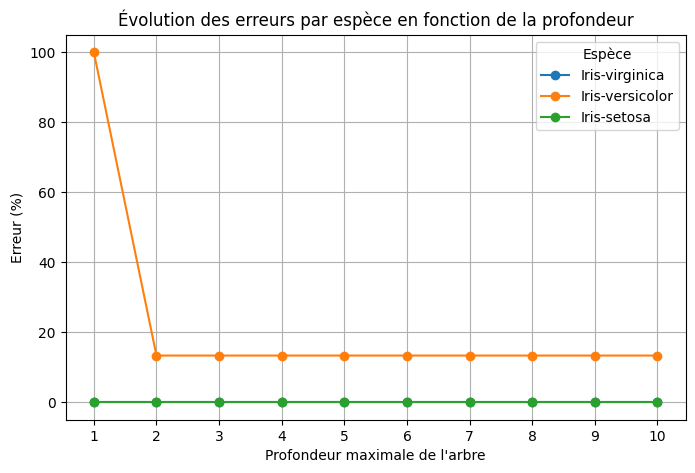

In [13]:
plt.figure(figsize=(8, 5))

for species in error_table.columns:
    plt.plot(
        error_table.index,
        error_table[species],
        marker="o",
        label=species
    )

plt.xlabel("Profondeur maximale de l'arbre")
plt.ylabel("Erreur (%)")
plt.title("Évolution des erreurs par espèce en fonction de la profondeur")
plt.xticks(error_table.index)  # pour que toutes les profondeurs soient visibles
plt.legend(title="Espèce")
plt.grid(True)
plt.show()

## II) Sklearn Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

X_iris = df_train[["PetalLengthCm", "PetalWidthCm"]].values
y_iris = df_train["Species"].values

X_iris_valid = df_valid[["PetalLengthCm", "PetalWidthCm"]].values
y_iris_valid = df_valid["Species"].values

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [15]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=["PetalLengthCm", "PetalWidthCm"], class_names=df["Species"].unique(),
    rounded=True,
    filled=True
    )


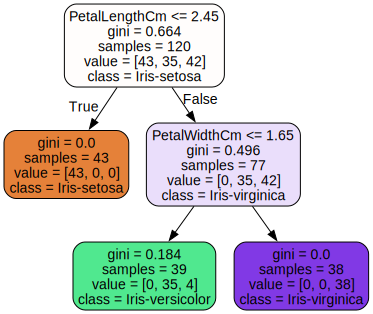

In [16]:
from graphviz import Source 

Source.from_file("iris_tree.dot")

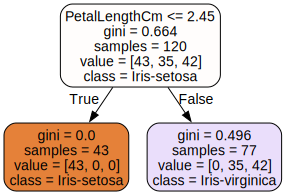

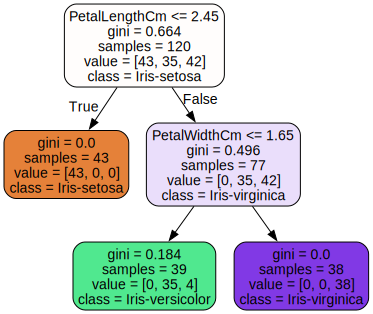

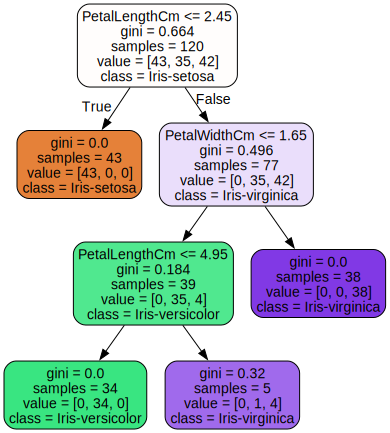

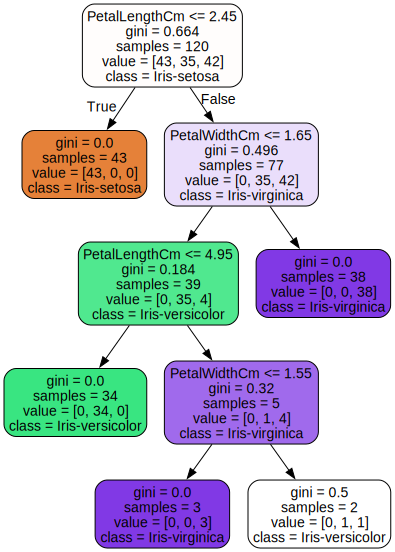

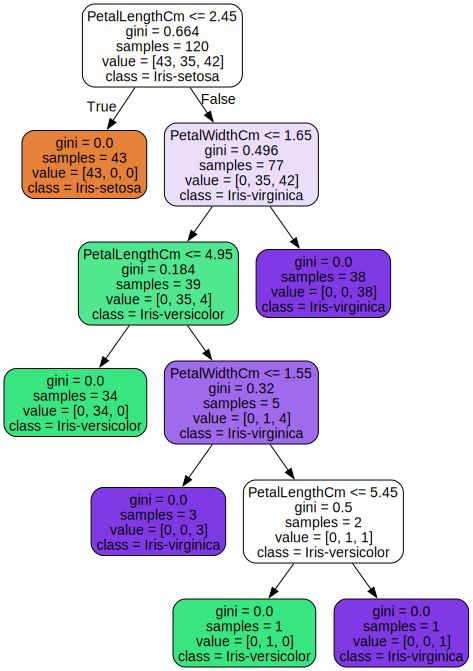

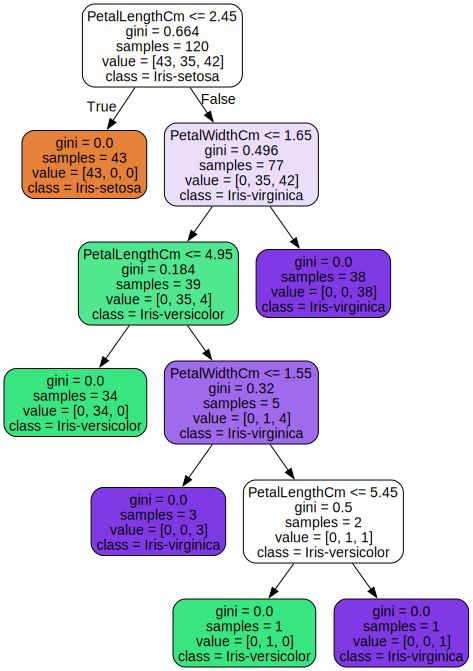

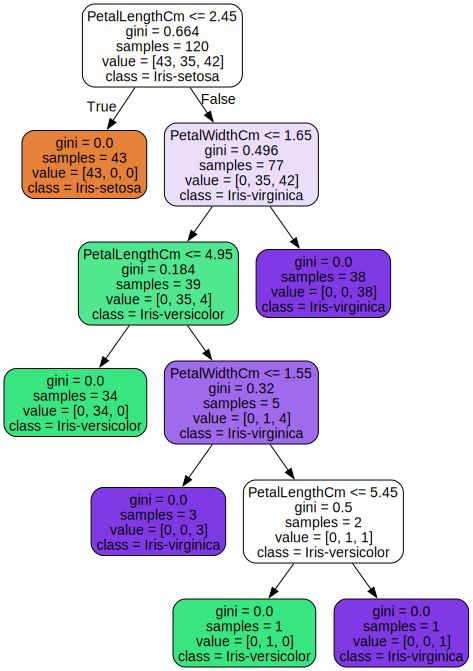

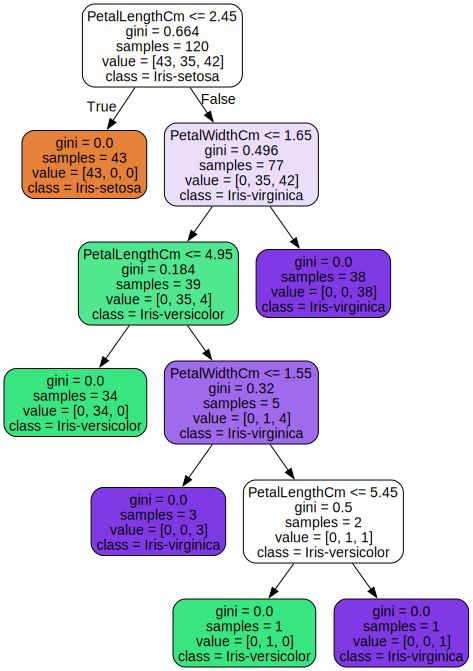

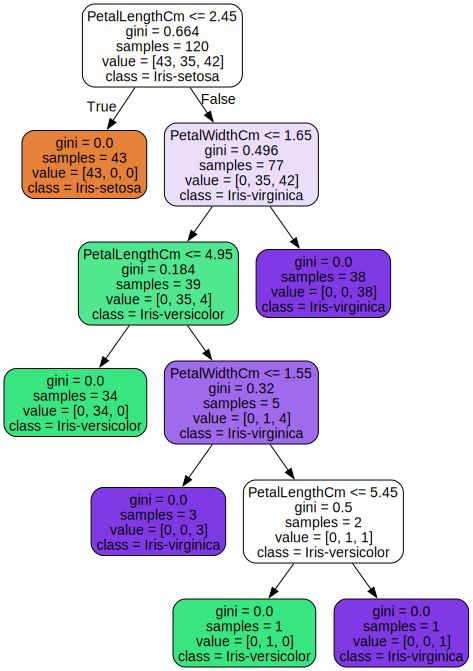

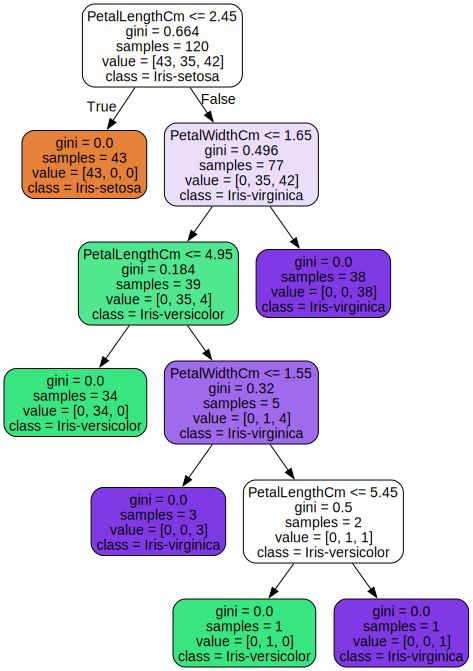

,Iris-setosa,Iris-versicolor,Iris-virginica
1,0.0,100.000000,0.0
2,0.0,13.333333,0.0
3,0.0,13.333333,0.0
4,0.0,13.333333,0.0
5,0.0,13.333333,0.0
6,0.0,13.333333,0.0
7,0.0,13.333333,0.0
8,0.0,13.333333,0.0
9,0.0,13.333333,0.0
10,0.0,13.333333,0.0


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
import pandas as pd
import numpy as np

depths_to_test = list(range(1, 11))

# List of the classes
species_list = np.unique(y_iris)

# Error rate Dataframe (rows = depths, columns = classes)
error_table = pd.DataFrame(0.0, index=depths_to_test, columns=species_list)

for depth in depths_to_test:
    tree_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_clf.fit(X_iris, y_iris)

    # Predictions on the validation set
    y_pred = tree_clf.predict(X_iris_valid)

    # Calculation of error rate for each class
    for species in species_list:
        mask = (y_iris_valid == species)  # indexes of this class
        error_rate = (y_pred[mask] != y_iris_valid[mask]).mean() * 100
        error_table.loc[depth, species] = error_rate

    # (Optionnal) Export the decision tree in a dot format
    dot_file = f"iris_tree_{depth}.dot"
    export_graphviz(
        tree_clf,
        out_file=dot_file,
        feature_names=["PetalLengthCm", "PetalWidthCm"],
        class_names=species_list,
        rounded=True,
        filled=True
    )

    # print the decision tree in the notebook
    display(Source.from_file(dot_file))

# print the error rate table
display(error_table)

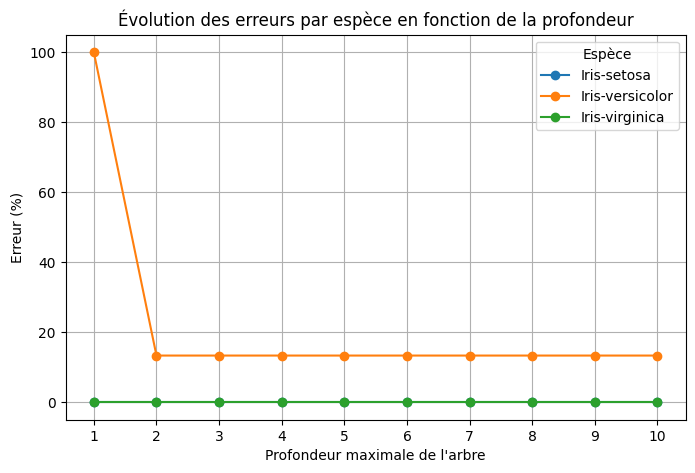

In [ ]:
plt.figure(figsize=(8, 5))

for species in error_table.columns:
    plt.plot(
        error_table.index,
        error_table[species],
        marker="o",
        label=species
    )

plt.xlabel("Profondeur maximale de l'arbre")
plt.ylabel("Erreur (%)")
plt.title("Évolution des erreurs par espèce en fonction de la profondeur")
plt.xticks(error_table.index)  
plt.legend(title="Espèce")
plt.grid(True)
plt.show()